# 3D  Medical Image Attack


### Startup

In [ ]:
import cv2
import numpy as np

try:
    import breaching
except ModuleNotFoundError:

    import os; os.chdir("..")
    import breaching
    
import torch
%load_ext autoreload
%autoreload 2

import math

# Redirects logs directly into the jupyter notebook
import logging, sys
logging.basicConfig(level=logging.INFO, handlers=[logging.StreamHandler(sys.stdout)], format='%(message)s')
logger = logging.getLogger()

In [2]:
import nibabel as nib
import os

def print_slice_count_and_spacing(nifty_path):
    try:
        # Load the NIfTI file
        img = nib.load(nifty_path)
        
        # Get the data array from the NIfTI file
        data = img.get_fdata()
        
        # Get the header information from the NIfTI file
        header = img.header
        
        # Print the shape of the data array
        print(f"Shape of the data: {data.shape}")
        
        # Print the number of slices in the z-dimension
        print(f"Number of slices: {data.shape[2]}")
        
        # Print the voxel dimensions (spacing)
        voxel_dims = header.get_zooms()
        print(f"Voxel dimensions (spacing): {voxel_dims}")
        
    except Exception as e:
        print(f"Error loading {nifty_path}: {str(e)}")

# Replace 'your_nifty_file.nii' with the path to your NIfTI file
nifty_file_path = ''
print_slice_count_and_spacing(nifty_file_path)


Shape of the data: (512, 512, 45)
Number of slices: 45
Voxel dimensions (spacing): (0.714, 0.714, 8.0)


### Initialize cfg object and system setup:

In [3]:



cfg = breaching.get_config(overrides=["attack=imprint", "case/server=malicious-model-cah"])


          
device = torch.device(f'cuda') if torch.cuda.is_available() else torch.device('cpu')
torch.backends.cudnn.benchmark = cfg.case.impl.benchmark
setup = dict(device=device, dtype=getattr(torch, cfg.case.impl.dtype))
setup

Investigating use case single_imagenet with server type malicious_model.


{'device': device(type='cuda'), 'dtype': torch.float32}

### Modify config options here

This will load the full configuration object. This includes the configuration for the use case and threat model as `cfg.case` and the hyperparameters and implementation of the attack as `cfg.attack`. All parameters can be modified below, or overriden with `overrides=` as if they were cmd-line arguments.

You can use `.attribute` access to modify any of these configurations for the attack, or the case:

In [4]:

cfg.case.data.name = "MosMedData_3D"


cfg.case.data.default_clients =1

In [5]:


cfg.case.user.num_data_points = 16 # How many data points does this user own
cfg.case.data.batch_size = 1


cfg.case.server.model_modification.type = 'CuriousAbandonHonesty' # What type of Imprint block will be grafted to the model
cfg.case.server.model_modification.num_bins = 500 # How many bins are in the block

cfg.case.server.model_modification.position = None # '4.0.conv'
cfg.case.server.model_modification.connection = 'addition'

# Unnormalized data:
cfg.case.data.normalize = False
cfg.case.server.model_modification.mu = 0
cfg.case.server.model_modification.sigma = 0.5
cfg.case.server.model_modification.scale_factor = 1 - 0.990
cfg.attack.breach_reduction = None # Will be done manually


In [6]:
cfg.case.model="ResNet18"


In [7]:
cfg.case.server.model_modification.type

'CuriousAbandonHonesty'

### Instantiate all parties

The following lines generate "server, "user" and "attacker" objects and print an overview of their configurations.

In [ ]:
user, server, model, loss_fn = breaching.cases.construct_case(cfg.case, setup)
attacker = breaching.attacks.prepare_attack(server.model, server.loss, cfg.attack, setup)


In [8]:
breaching.utils.overview(server, user, attacker)

Model architecture ResNet18 loaded with 86,636,993 parameters and 9,620 buffers.
Overall this is a data ratio of      36:1 for target shape [16, 3, 224, 224] given that num_queries=1.
User (of type UserSingleStep) with settings:
    Number of data points: 16

    Threat model:
    User provides labels: False
    User provides buffers: False
    User provides number of data points: True

    Data:
    Dataset: MosMedData_3D
    user: 0
    
        
Server (of type MaliciousModelServer) with settings:
    Threat model: Malicious (Analyst)
    Number of planned queries: 1
    Has external/public data: False

    Model:
        model specification: ResNet18
        model state: default
        public buffers: True

    Secrets: {'ImprintBlock': {'weight_idx': 0, 'bias_idx': 1, 'shape': torch.Size([3, 224, 224]), 'structure': 'sparse'}}
    
Attacker (of type ImprintAttacker).


### Simulate an attacked FL protocol

This exchange is a simulation of a single query in a federated learning protocol. The server sends out a `server_payload` and the user computes an update based on their private local data. This user update is `shared_data` and contains, for example, the parameter gradient of the model in the simplest case. `true_user_data` is also returned by `.compute_local_updates`, but of course not forwarded to the server or attacker and only used for (our) analysis.

In [9]:
server_payload = server.distribute_payload()
shared_data, true_user_data = user.compute_local_updates(server_payload)  

Computing user update on user 0 in model mode: eval.


NRRD file saved at: reconstructed_processed.nrrd


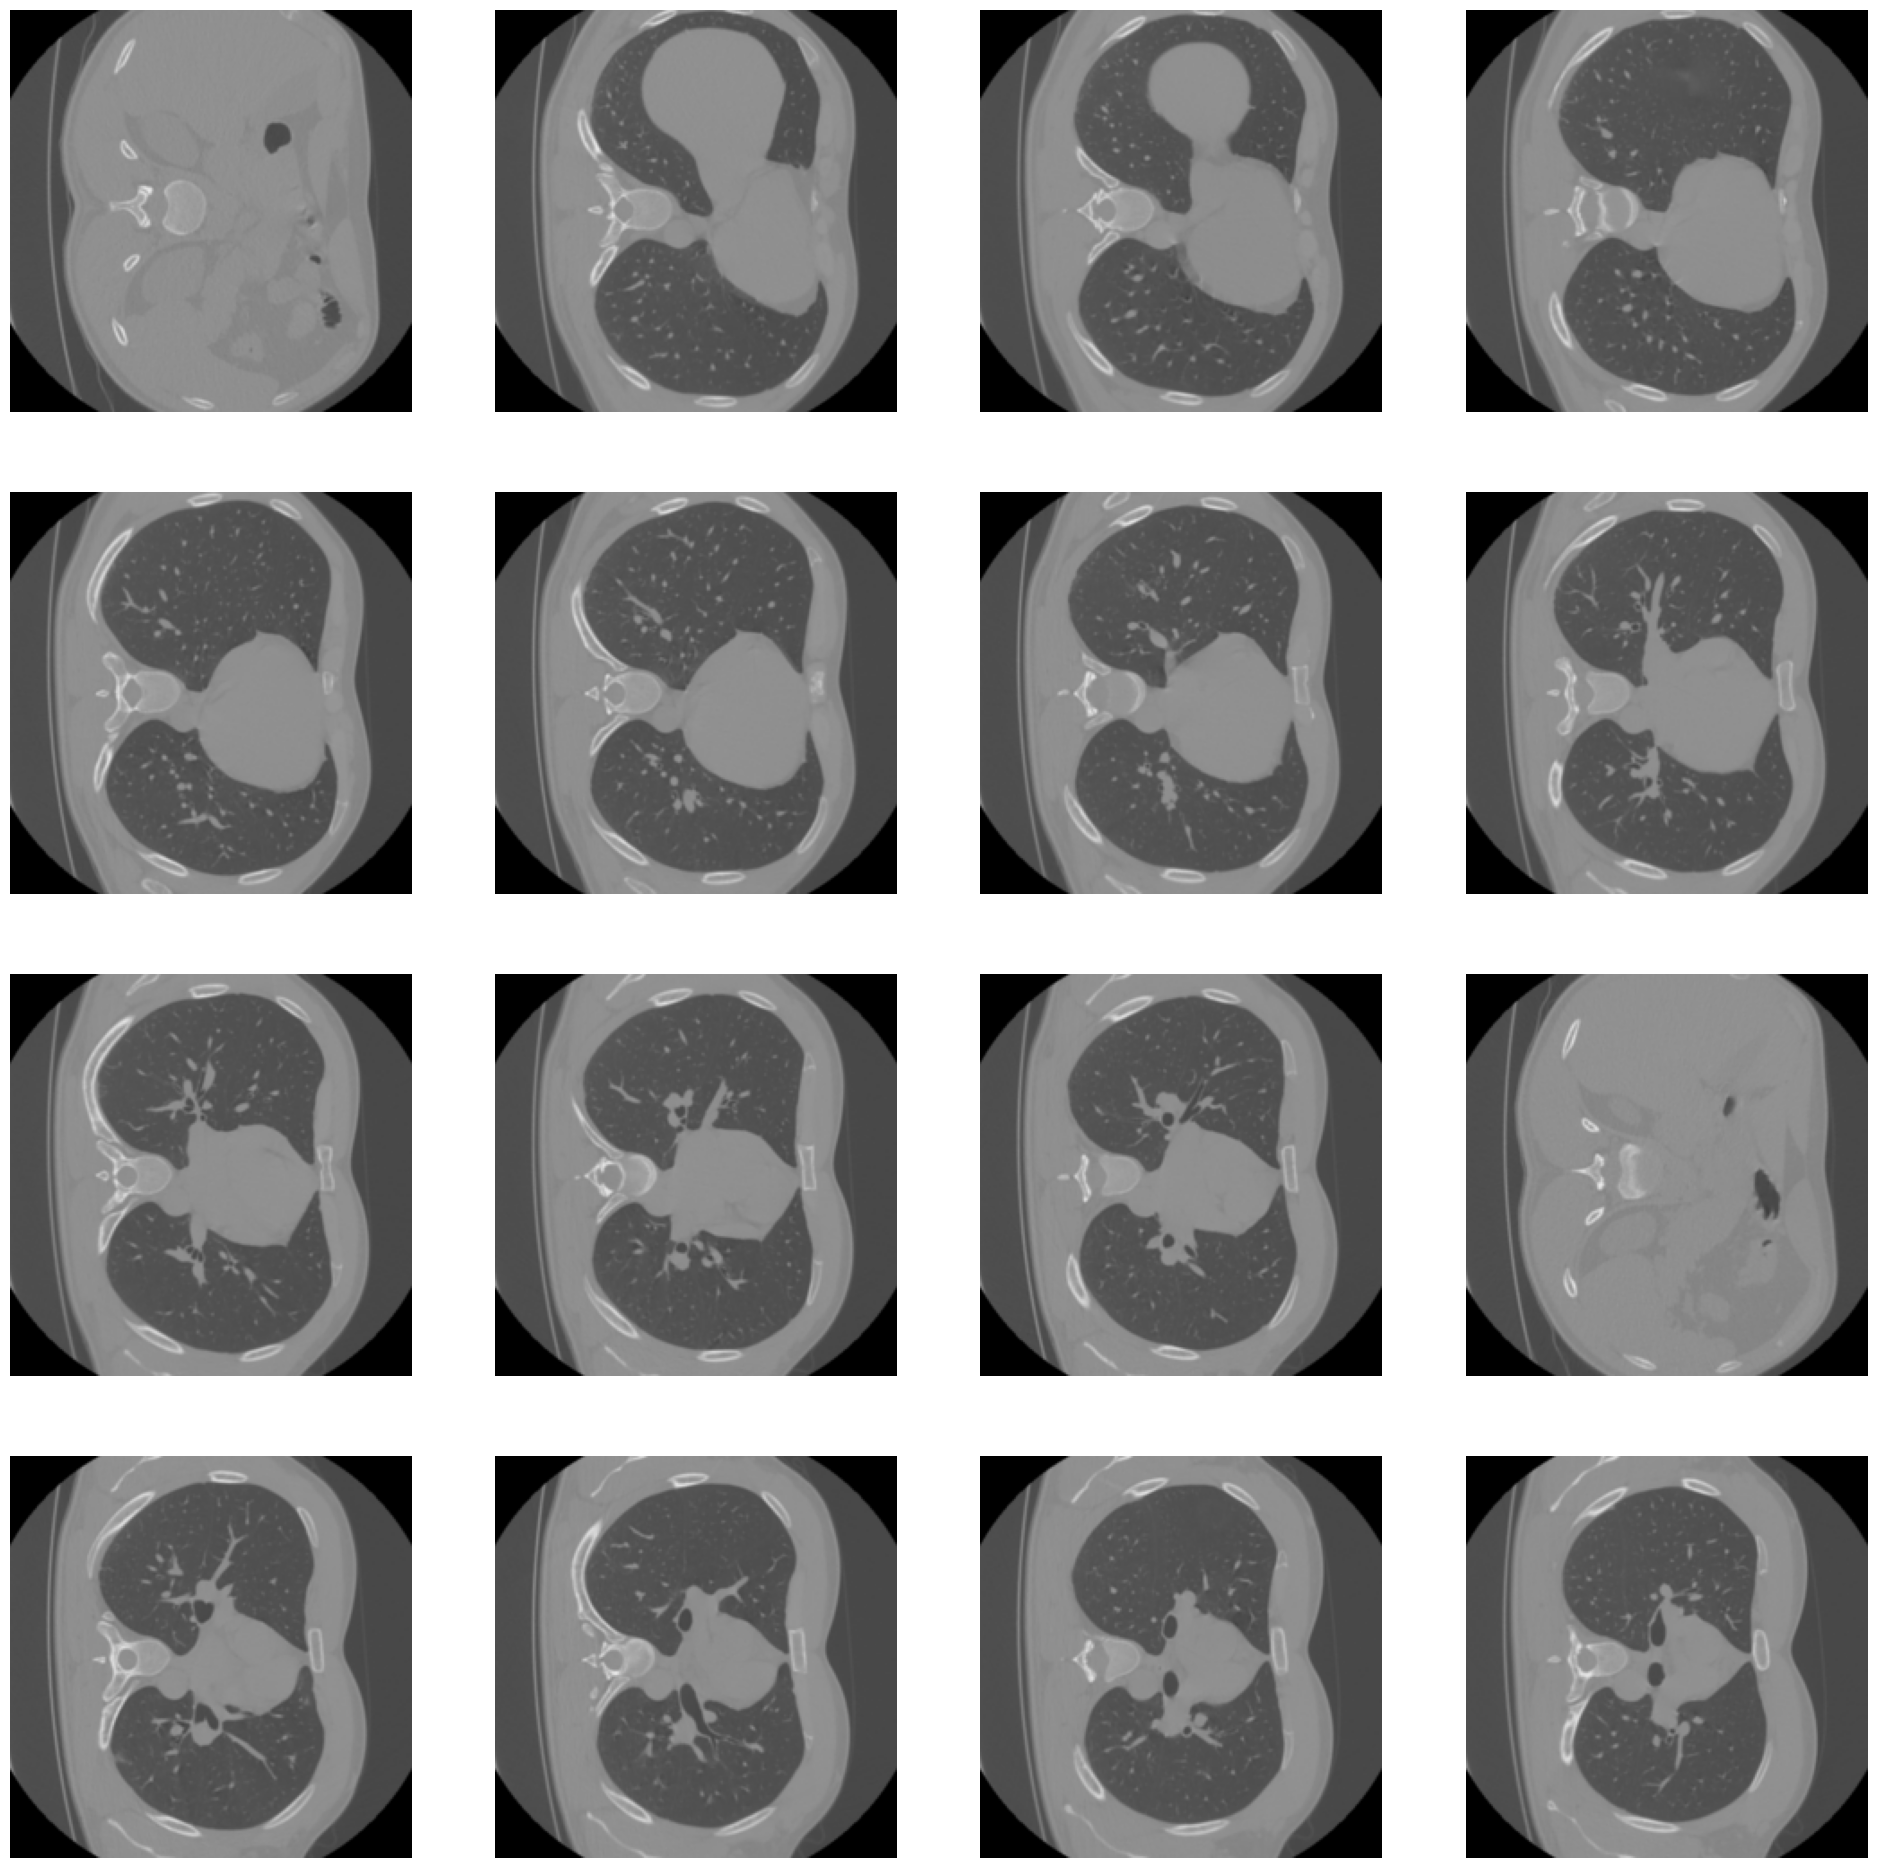

In [10]:
user.plot(true_user_data)

### Reconstruct user data:

Now we launch the attack, reconstructing user data based on only the `server_payload` and the `shared_data`. 

For this attack, we also share secret information from the malicious server with the attack (`server.secrets`), which here is the location and structure of the imprint block.

In [11]:
import time
local_time = time.time()
reconstructed_user_data, stats = attacker.reconstruct([server_payload], [shared_data], server.secrets, 
                                                      dryrun=cfg.dryrun)

Initially produced 296 hits.


Next we'll evaluate metrics, comparing the `reconstructed_user_data` to the `true_user_data`.

### Remove mixed images by direct GT comparison

In [12]:
reconstructed = torch.zeros_like(true_user_data["data"])
for sample in reconstructed_user_data["data"]:
        l2_dists = (sample[None] - true_user_data["data"]).pow(2).mean(dim=[1, 2, 3])
        min_dist, min_idx = l2_dists.min(dim=0)
        if min_dist < 1e-1:
            reconstructed[min_idx] = sample
reconstructed_user_data = dict(data=reconstructed, labels=None)

In [13]:
#metrics = breaching.analysis.report(reconstructed_user_data, true_user_data, [server_payload], 
                                    #server.model, order_batch=True, compute_full_iip=False, 
                                    #cfg_case=cfg.case, setup=setup)

And finally, we also plot the reconstructed data:

NRRD file saved at: reconstructed_processed.nrrd


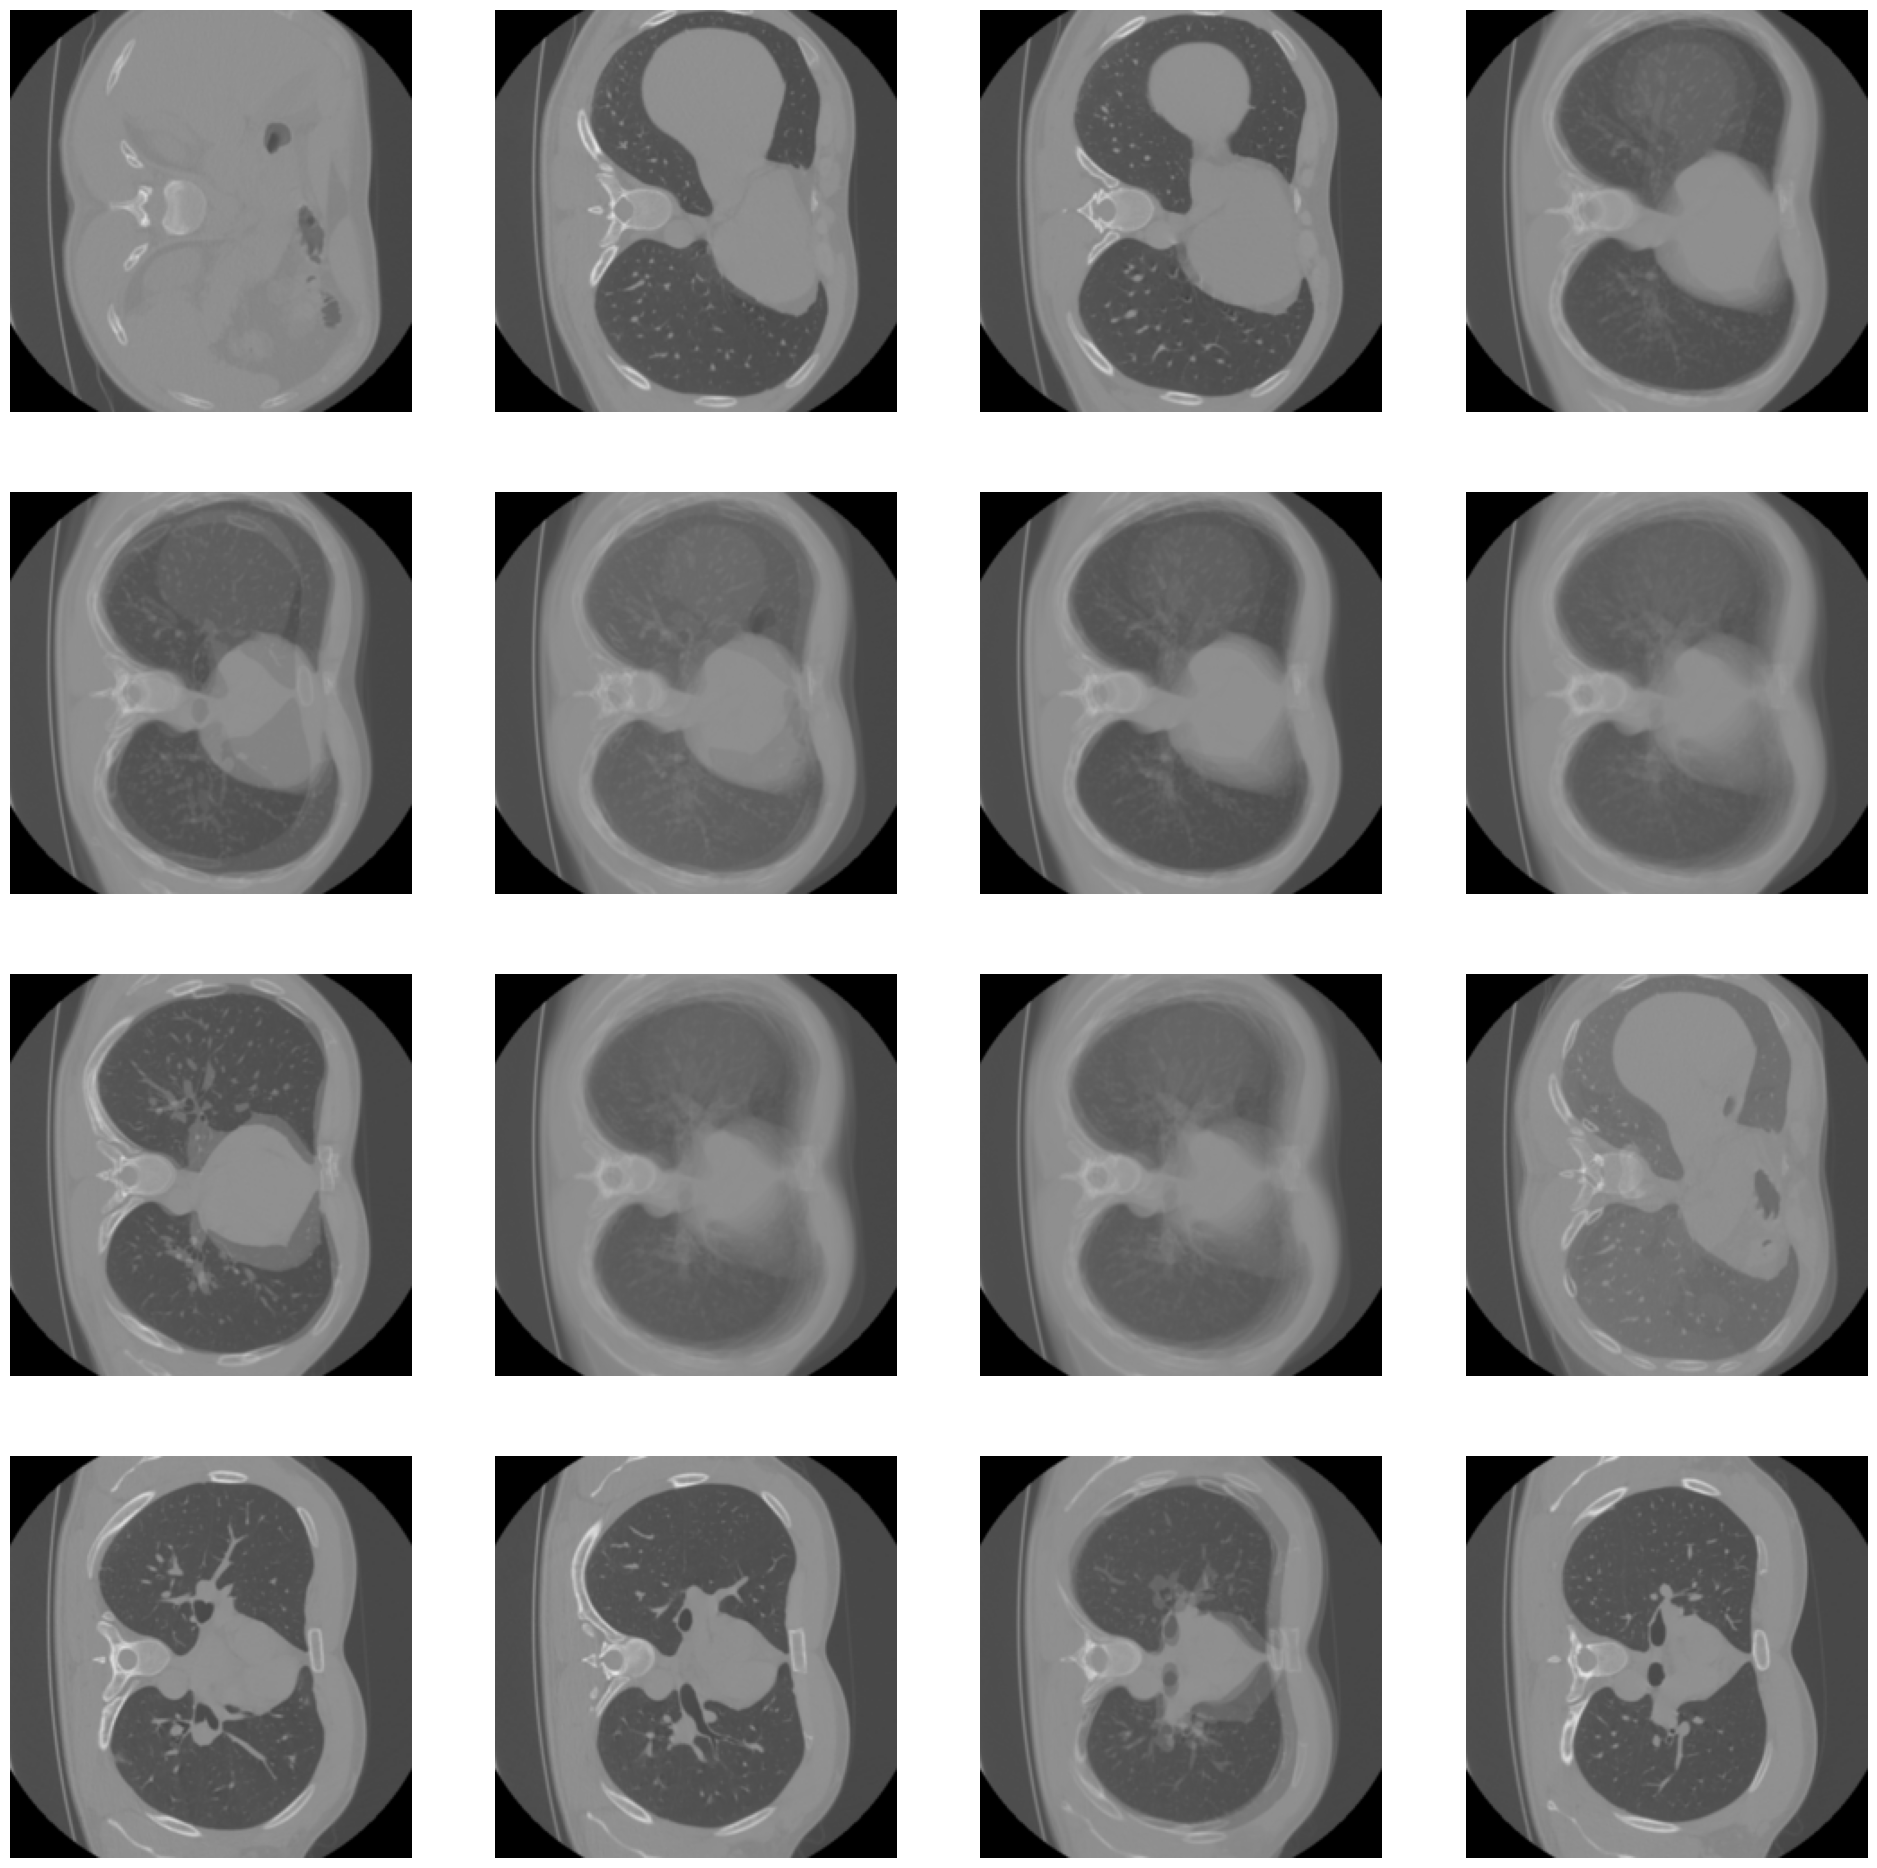

In [14]:
user.plot(reconstructed_user_data)

In [15]:
#print(reconstructed_user_data)

In [ ]:


#import breaching
#import time
#breaching.utils.save_reconstruction(reconstructed_user_data, [server_payload], true_user_data, cfg,side_by_side=True)